In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as st
import RELACS as rel
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Estimate H3K79me2 bulck decrease consequent to EPZ treatment using RELACS double ratio method and densitometric analysis of immunoblotting results

In [76]:
%%bash

### count reads in Bam for DMSO and EPZ NPC48h ###

for i in ../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC*rep*.bam ; do \
echo $(basename $i) | tr "\n" "\t" >> ../INPUT_DATA/counts_NPC48h_consensusSetAllPeaks.txt ; samtools view -c -L ../INPUT_DATA/EnrichedRegions_allMarks_normed_binned.bed $i >> ../INPUT_DATA/counts_NPC48h_consensusSetAllPeaks.txt; done

In [82]:
%%bash

### count reads in Bam for DMSO and EPZ mESC ###

for i in ../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC*rep*.bam ; do \
echo $(basename $i) | tr "\n" "\t" >> ../INPUT_DATA/counts_mESC_consensusSetAllPeaks.txt ; samtools view -c -L ../INPUT_DATA/EnrichedRegions_allMarks_normed_binned.bed $i >> ../INPUT_DATA/counts_mESC_consensusSetAllPeaks.txt; done

In [2]:
### CREATE REFERENCE DATAFRAME FOR NPC48h ###

reads_NPC = pd.read_csv("../INPUT_DATA/counts_NPC48h_consensusSetAllPeaks.txt", sep="\t", names=["sample", "read_counts"])
reads_NPC["rep"] = [i.split("_")[2] for i in reads_NPC["sample"]]
reads_NPC["treat"] = [i.split("_")[1] for i in reads_NPC["sample"]]
reads_NPC["mark"] = [i.split("_")[3].split(".")[0] for i in reads_NPC["sample"]]
reads_NPC

,sample,read_counts,rep,treat,mark
0,iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam,3108668,rep1,DMSO,H3K27ac
1,iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam,4420814,rep1,DMSO,H3K27me3
2,iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam,9271276,rep1,DMSO,H3K36me3
3,iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam,3578157,rep1,DMSO,H3K4me1
4,iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam,4579274,rep1,DMSO,H3K4me3
5,iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam,8726767,rep1,DMSO,H3K79me2
6,iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam,3614519,rep1,DMSO,H3K9me3
7,iNPC_DMSO_rep1_Input.filtered.bam,2378340,rep1,DMSO,Input
8,iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam,6451688,rep2,DMSO,H3K27ac
9,iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam,7173790,rep2,DMSO,H3K27me3


In [3]:
### CREATE REFERENCE DATAFRAME FOR mESC ###

reads_ESC = pd.read_csv("../INPUT_DATA/counts_mESC_consensusSetAllPeaks.txt", sep="\t", names=["sample", "read_counts"])
reads_ESC["rep"] = [i.split("_")[2] for i in reads_ESC["sample"]]
reads_ESC["treat"] = [i.split("_")[1] for i in reads_ESC["sample"]]
reads_ESC["mark"] = [i.split("_")[3].split(".")[0] for i in reads_ESC["sample"]]
reads_ESC

,sample,read_counts,rep,treat,mark
0,mESC_DMSO_rep1_H3K27ac_merged.filtered.bam,32975824,rep1,DMSO,H3K27ac
1,mESC_DMSO_rep1_H3K27me3_merged.filtered.bam,15283463,rep1,DMSO,H3K27me3
2,mESC_DMSO_rep1_H3K36me3_merged.filtered.bam,26342999,rep1,DMSO,H3K36me3
3,mESC_DMSO_rep1_H3K4me1_merged.filtered.bam,18586000,rep1,DMSO,H3K4me1
4,mESC_DMSO_rep1_H3K4me3_merged.filtered.bam,21817453,rep1,DMSO,H3K4me3
5,mESC_DMSO_rep1_H3K79me2_merged.filtered.bam,8199976,rep1,DMSO,H3K79me2
6,mESC_DMSO_rep1_H3K9me3_merged.filtered.bam,10925542,rep1,DMSO,H3K9me3
7,mESC_DMSO_rep1_Input.filtered.bam,9136221,rep1,DMSO,Input
8,mESC_DMSO_rep2_H3K27ac_merged.filtered.bam,45477406,rep2,DMSO,H3K27ac
9,mESC_DMSO_rep2_H3K27me3_merged.filtered.bam,14146795,rep2,DMSO,H3K27me3


# PLOT RESULTS

### Densiometric analysis detailed:

1. Estimate signal intensity using ImageJ for H3K79me2 and H3;
2. Divide each H3K79me2 sample for the respective H3;
3. Divide each sample by the value of a reference sample, so that each sample is expressed as a fraction of one reference sample **(DATA IMPORTED IN THIS NOTEBOOK ARE THE RESULT OF THIS STEP)**;
4. For each replicate, divide the EPZ signal for the corresponding DMSO signal;

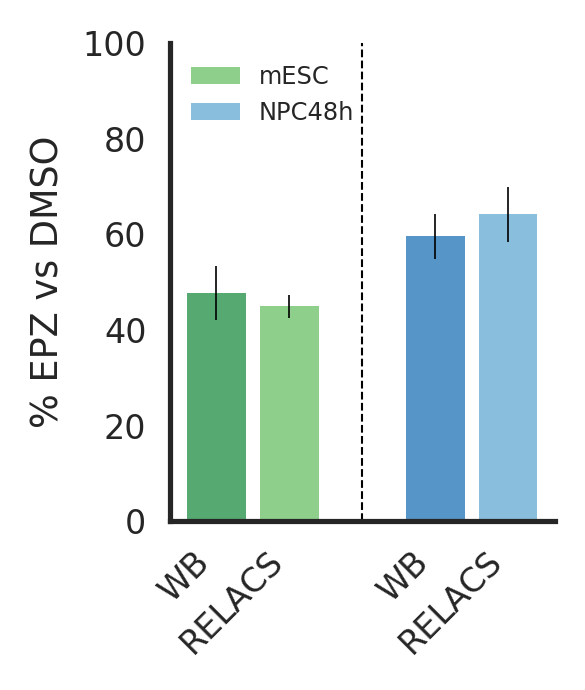

In [5]:
### Densitometric data: divide the EPZ signal for the corresponding DMSO signal from the same differentiation batch ###

""""
DATA STRUCTURE:
    data = array[DMSO_rep1, DMSO_rep2, DMSO_rep3, EPZ_rep1, EPZ_rep2, EPZ_rep3] / array[DMSO_rep1, DMSO_rep2, DMSO_rep3, DMSO_rep1, DMSO_rep2, DMSO_rep3]
"""
data_ESC = (np.array([1,0.826356997,0.998894065, 0.456024314,0.459333096,0.421538331])/np.array([1,0.826356997,0.998894065,1,0.826356997,0.998894065]))*100
data_NPC = (np.array([1, 0.891848331, 1.378383225, 0.599578311, 0.477994016, 0.897557357]) / np.array([1, 0.891848331, 1.378383225,1, 0.891848331, 1.378383225]))*100


### PLOT RESULTS ###

fig1,ax1 = plt.subplots(dpi=300, figsize=(2.05,2.4)) 
dfs = [reads_ESC,reads_NPC]

cols_ = sns.color_palette("Greens_r").as_hex()
cols_ = [cols_[i] for i in range(4)[::-2]]
cols1 = sns.color_palette("Blues_r").as_hex()
cols1 = [cols1[i] for i in range(4)[::-2]]
cols=[cols_[0],cols1[0]]
labels = ["mESC","NPC48h"]


### COMPUTE DOUBLE RATIOS FOR RELACS QUANTIFICATION ###

for p in range(len(dfs)):
    
    for i in ["H3K79me2"]:
        
        reads = dfs[p]

        inp = reads.loc[reads.mark == "Input"][["read_counts"]]

        markss = reads.loc[reads.mark == i][["read_counts"]]

        norm = markss.values/inp.values

        ratios = []
        percent = []
        for k in norm:
            a = list()
            b = list()
            for j in norm:
                a.append(k/j)
                b.append((k*100)/j)
            ratios.append(list(a))
            percent.append(b)
        iNPC = np.mean(np.log2(np.array(ratios)[2:,:2]))
        iNPC_perc =  np.mean(np.array(percent)[2:,:2]) 
        iNPC_std = np.std(np.log2(np.array(ratios)[2:,:2]))
        iNPC_perc_std = np.std(np.array(percent)[2:,:2]) 
    
        if p == 0:
            ax1.bar([p+1],[iNPC_perc], width=0.8, color = cols[p], label=labels[p])
            ax1.errorbar([p+1],[iNPC_perc],  yerr=iNPC_perc_std, linewidth=0.4, capsize=0, color='k')
        else:
            ax1.bar([p+3],[iNPC_perc], width=0.8,color = cols[p], label=labels[p])
            ax1.errorbar([p+3],[iNPC_perc],  yerr=iNPC_perc_std, linewidth=0.4, capsize=0, color='k')


ax1.set_ylim((0,100))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.bar([0],[data_ESC[3:].mean()], color=cols_[1], width=0.8,alpha=0.8)
ax1.errorbar([0],[data_ESC[3:].mean()],  yerr=np.std(data_ESC[3:]), linewidth=0.4, capsize=0, color='k')

ax1.bar([3],[data_NPC[3:].mean()], color=cols1[1], width=0.8,alpha=0.8)
ax1.errorbar([3],[data_NPC[3:].mean()],  yerr=np.std(data_NPC[3:]), linewidth=0.4, capsize=0, color='k')

ax1.axvline(2, color='k', linewidth=0.5, linestyle="--")

ax1.set_xticks([0,1,3,4])
ax1.set_xticklabels(["WB","RELACS","WB","RELACS"], ha="right", rotation=45)
ax1.legend(loc=2, fontsize="xx-small")
ax1.set_ylabel("% EPZ vs DMSO")


plt.tight_layout()

plt.savefig("../FIGURES/H3K79me2_global_change_mESC_NPC48h.pdf")


# Compute locus specific quantification of H3K79me3 loss is each cluster identified in Fig 2d

In [135]:
%%bash

### RETRIEVE COUNTS FOR H3K79me2 ON A 3KB WINDOW DOWNSTREAM OF PROTEIN CODING GENES IN mESC AND NPC48h ###

multiBamSummary BED-file \
--BED ../../figure_2/INPUT_DATA/3kb_DownTSS_ProteinCoding.bed \
-b /home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*_H3K79me2_merged.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*_H3K79me2_merged.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC_*rep*_Input.filtered.bam \
/home/ferrari/ferrari/PhD_project/reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC_*rep*_Input.filtered.bam \
-o ../INTERMEDIATE_FILES/H3K79me2_NPC48h_vs_mESC.npz \
--outRawCounts ../INTERMEDIATE_FILES/H3K79me2_NPC48h_vs_mESC.counts \
--smartLabels \
-p 20 \
-bl /data/repository/organisms/GRCm38_ensembl/DKFZ/GRCm38_General_readAttractingRegions.UseThisOne.bed \
-e \
--samFlagInclude 2 

Number of bins found: 21965


In [6]:
### PREPROCESS ###

df = pd.read_csv("../INTERMEDIATE_FILES/H3K79me2_NPC48h_vs_mESC.counts", sep="\t")
list_of_cols = [[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15]]
counts_sumRep = rel.preprocess_deeptools(df,merge_rep=True, list_of_columns=list_of_cols)
cT_inp = rel.Normalize_T(counts_sumRep, log=True, input_norm=True)
cT_inp.columns = ["mESC_DMSO","mESC_EPZ","NPC48h_DMSO","NPC48h_EPZ","mESC_DMSO_inp","mESC_EPZ_inp","NPC48h_DMSO_inp","NPC48h_EPZ_inp"]

/home/ferrari/.local/lib/python3.6/site-packages/RELACS.py:91: RuntimeWarning: divide by zero encountered in log2
  counts_norm = np.log2(counts_norm)


In [7]:
### RETRIEVE CLUSTERED WINDOWS DOWNSTREAM OF TSS AND ASSOCIATE THEM TO GENES

cl = pd.read_csv("../../figure_2/INTERMEDIATE_FILES/H3K79me2_3kbDownTSS_mESC_NPC48h_ultraheatmap_5cl.txt",sep="\t")
cl_1 = cl[cl.deepTools_group =="cluster_1"]
cl_2 = cl[cl.deepTools_group =="cluster_2"]
cl_3 = cl[cl.deepTools_group =="cluster_3"]
cl_4 = cl[cl.deepTools_group =="cluster_4"]
cl_5 = cl[cl.deepTools_group =="cluster_5"]

tr = pd.read_csv("../../figure_2/INPUT_DATA/3kb_DownTSS_ProteinCoding.bed",sep="\t",header=None, names=["chr","start","end","gene_ID","score","strand","gene_name","length"])
tr.index = tr["gene_ID"]
tr["coord_ID"] = ['{}_{}_{}'.format(tr["chr"][i],tr["start"][i],tr["end"][i]) for i in tr.index]
tr_1 = tr.loc[cl_1.name]
tr_2 = tr.loc[cl_2.name]
tr_3 = tr.loc[cl_3.name]
tr_4 = tr.loc[cl_4.name]
tr_5 = tr.loc[cl_5.name]

-1.0078195044592997
-0.5894084057523479


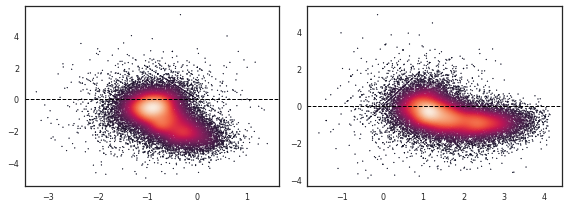

In [8]:
### VISUALIZE MA PLOT WITHOUT CLUSTERING REGIONS
fig, ax = plt.subplots(1,2, figsize=(8,3))
lfc_mESC = rel.MA_samp(cT_inp, ["mESC_DMSO", "mESC_EPZ"], ax=ax[0])[1]
lfc_NPC48h = rel.MA_samp(cT_inp, ["NPC48h_DMSO", "NPC48h_EPZ"],ax=ax[1])[1]

/home/ferrari/.local/lib/python3.6/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


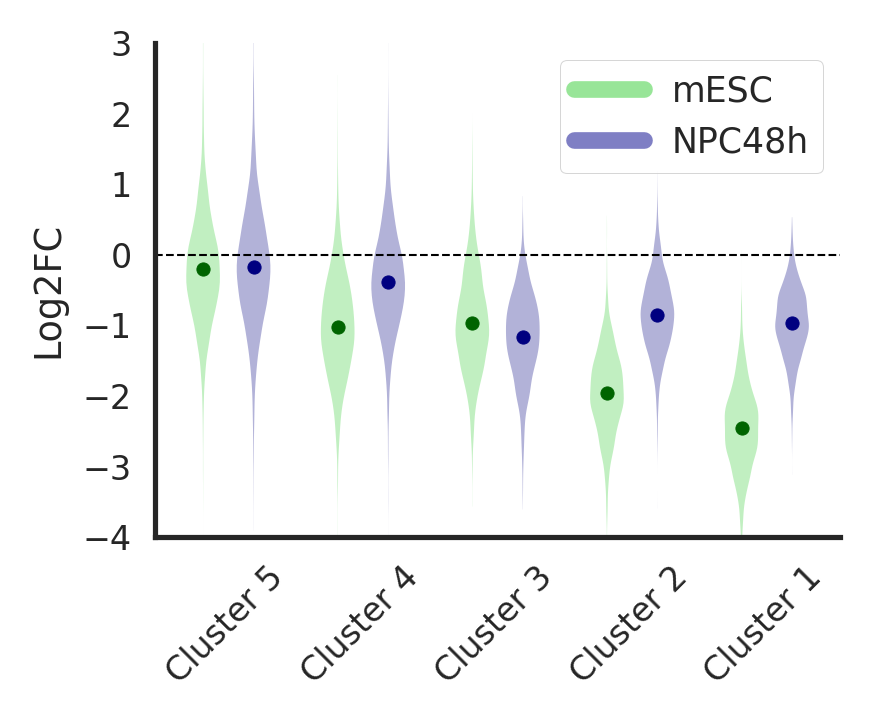

In [9]:
### PLOT DISCRIBUTION OF LOG2 FOLD CHANGES OF H3K79me2 SIGNAL OF EACH WINDOW FOR THE CONTRAST EPZ VS DMSO IN mESC and NPC48h ###

fig,ax=plt.subplots(dpi=300,figsize=(3,2.5))

custom_lines = [Line2D([0], [0], color='limegreen', lw=4,alpha=0.5),
                Line2D([0], [0], color='darkblue', lw=4, alpha=0.5)]

vp_2 = ax.violinplot(np.array([lfc_NPC48h[list(tr_1.coord_ID.values)].dropna(), 
                  lfc_NPC48h[list(tr_2.coord_ID.values)].dropna(), 
                  lfc_NPC48h[list(tr_3.coord_ID.values)].dropna(), 
                  lfc_NPC48h[list(tr_4.coord_ID.values)].dropna(),
                  lfc_NPC48h[list(tr_5.coord_ID.values)].dropna()])[::-1], 
                  np.array(range(0,10,2))+0.75, showmeans=False, showextrema=False)

vp_3 = ax.violinplot(np.array([lfc_mESC[list(tr_1.coord_ID.values)].dropna(), 
                  lfc_mESC[list(tr_2.coord_ID.values)].dropna(), 
                  lfc_mESC[list(tr_3.coord_ID.values)].dropna(), 
                  lfc_mESC[list(tr_4.coord_ID.values)].dropna(),
                  lfc_mESC[list(tr_5.coord_ID.values)].dropna()])[::-1], 
                  np.array(range(0,10,2)), showmeans=False, showextrema=False)

ax.scatter(np.array(range(0,10,2))+0.75, np.array([lfc_NPC48h[list(tr_1.coord_ID.values)].dropna().mean(), 
                  lfc_NPC48h[list(tr_2.coord_ID.values)].dropna().mean(), 
                  lfc_NPC48h[list(tr_3.coord_ID.values)].dropna().mean(), 
                  lfc_NPC48h[list(tr_4.coord_ID.values)].dropna().mean(),
                  lfc_NPC48h[list(tr_5.coord_ID.values)].dropna().mean()])[::-1],s=10,color='navy')

ax.scatter(np.array(range(0,10,2)), np.array([lfc_mESC[list(tr_1.coord_ID.values)].dropna().mean(), 
                  lfc_mESC[list(tr_2.coord_ID.values)].dropna().mean(), 
                  lfc_mESC[list(tr_3.coord_ID.values)].dropna().mean(), 
                  lfc_mESC[list(tr_4.coord_ID.values)].dropna().mean(),
                  lfc_mESC[list(tr_5.coord_ID.values)].dropna().mean()])[::-1],s=10,color='darkgreen')

ax.axhline(0,linestyle="--",linewidth=0.5,color='k')

for i in range(len(vp_2['bodies'])):
    vp_2['bodies'][i].set_facecolor('navy')
    vp_3['bodies'][i].set_facecolor('limegreen')

ax.legend(custom_lines, ['mESC','NPC48h'], fontsize='small', loc=1, frameon=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim((-4,3))
ax.set_ylabel("Log2FC")
plt.xticks(np.array(range(0,10,2))+0.33, np.array(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4','Cluster 5'])[::-1],rotation=45)

plt.tight_layout()

plt.savefig("../FIGURES/H3K79me2_LFC-EPZvsDMSO_violin.pdf")



-0.33130915417615286
-0.13012267211145256
-0.16989598665668712
-0.044954402147118044
-0.1094370554416545
-0.051730663179535535
-0.646242374476233
0.0


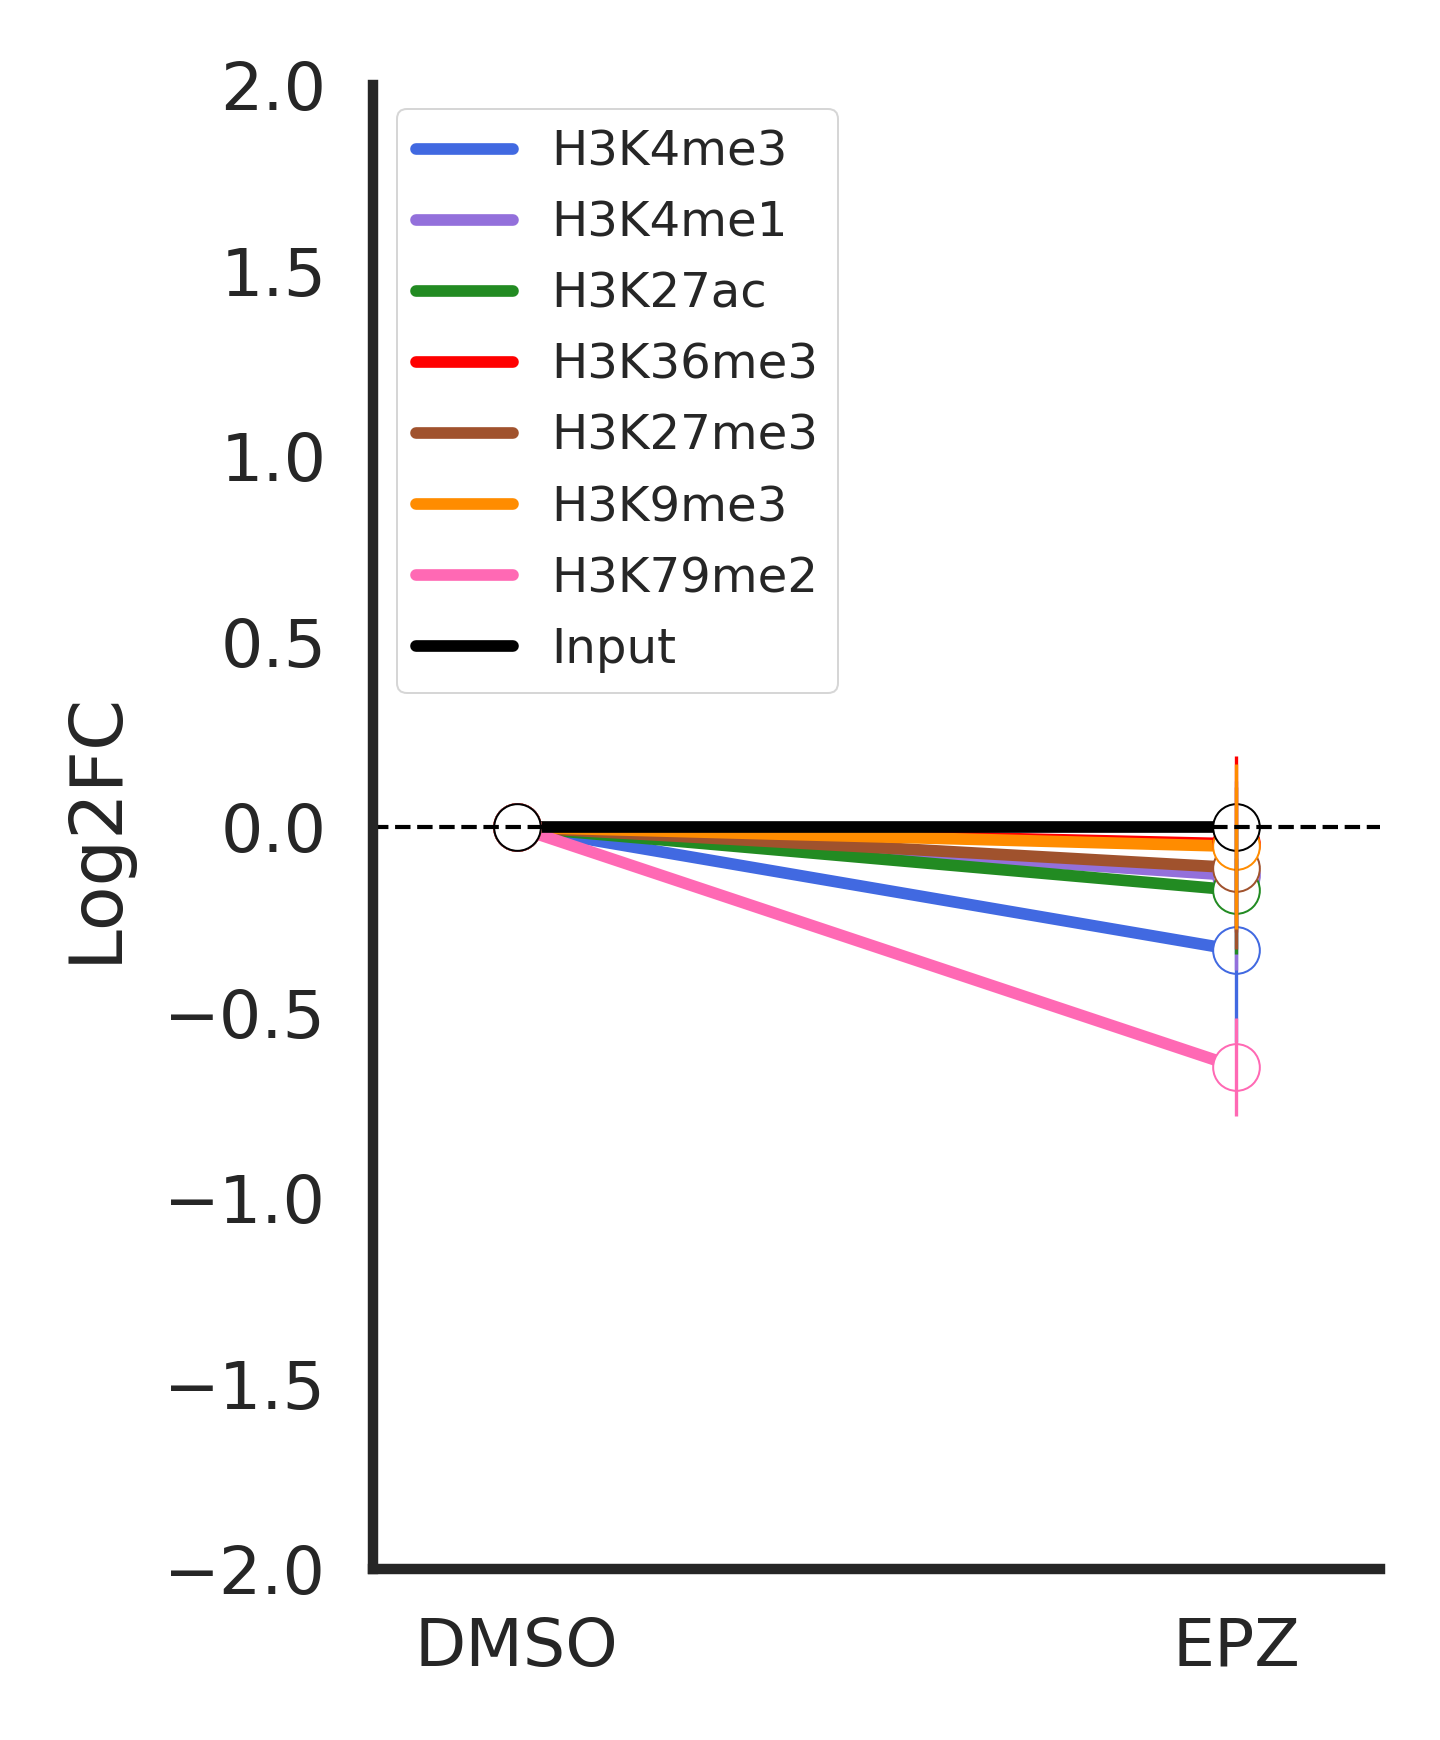

In [182]:
fig,ax = plt.subplots(dpi=600, figsize=(2.5,3))

cols={"H3K4me3":'royalblue',
      "H3K4me1":'mediumpurple',
      "H3K27ac":'forestgreen',
      "H3K36me3":'r',
      "H3K27me3":'sienna',
      "H3K9me3":'darkorange',
      "H3K79me2":'hotpink',
      "Input":'k'}

for i in ["H3K4me3","H3K4me1","H3K27ac","H3K36me3","H3K27me3","H3K9me3","H3K79me2","Input"]:#set(list(df_wt.mark)):
    
    inp = reads_NPC.loc[reads.mark == "Input"][["read_counts"]]
    

    markss = reads_NPC.loc[reads.mark == i][["read_counts"]]
#     print(markss)

    norm = markss.values/inp.values
    
   
    ratios = []
    for k in norm:
        a = list()
        for j in norm:
            a.append(k/j)
        ratios.append(list(a))
    iNPC = np.mean(np.log2(np.array(ratios)[2:,:2]))
    iNPC_std = np.std(np.log2(np.array(ratios)[2:,:2]))
#     mESC = np.mean(np.log2(np.array(ratios)[2:,:2]))
   
    ax.plot([0,1],[0,iNPC], label = i, zorder=0, color=cols[i])
    ax.errorbar([1],[iNPC],  yerr=iNPC_std, linewidth=0.4, capsize=0, color=cols[i])
    print(iNPC)
    ax.scatter([0,1],[0,iNPC], zorder=1,color=cols[i],edgecolor=cols[i], alpha=1, facecolor='white')
    
    ax.set_xticks(np.array([0,1]))
    ax.set_xticklabels(["DMSO","EPZ"])

    ax.legend(fontsize="xx-small", loc=2, frameon=True)
ax.set_ylabel("Log2FC")
ax.set_ylim(-2,2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.xlabel("differentiation trajectory")
#plt.annotate('', xy=(0.2, -0.1), xycoords='axes fraction', xytext=(0.8, -0.1), 
            #arrowprops=dict(arrowstyle="<-", color='k'))
#plt.title("NPC48h")
ax.set_xlim(-0.2,1.2)
ax.axhline(0, linewidth=0.5,linestyle='--', color='k')
plt.tight_layout()

plt.savefig("../FIGURES/Global_Change_NPC48h_EPZvsDMSO.pdf")

-0.22184929387921876
-0.14013744324049743
0.03218672251744553
-0.18845854811891843
-0.04795532910608634
-0.06264318091248795
-1.1561772845524327
0.0


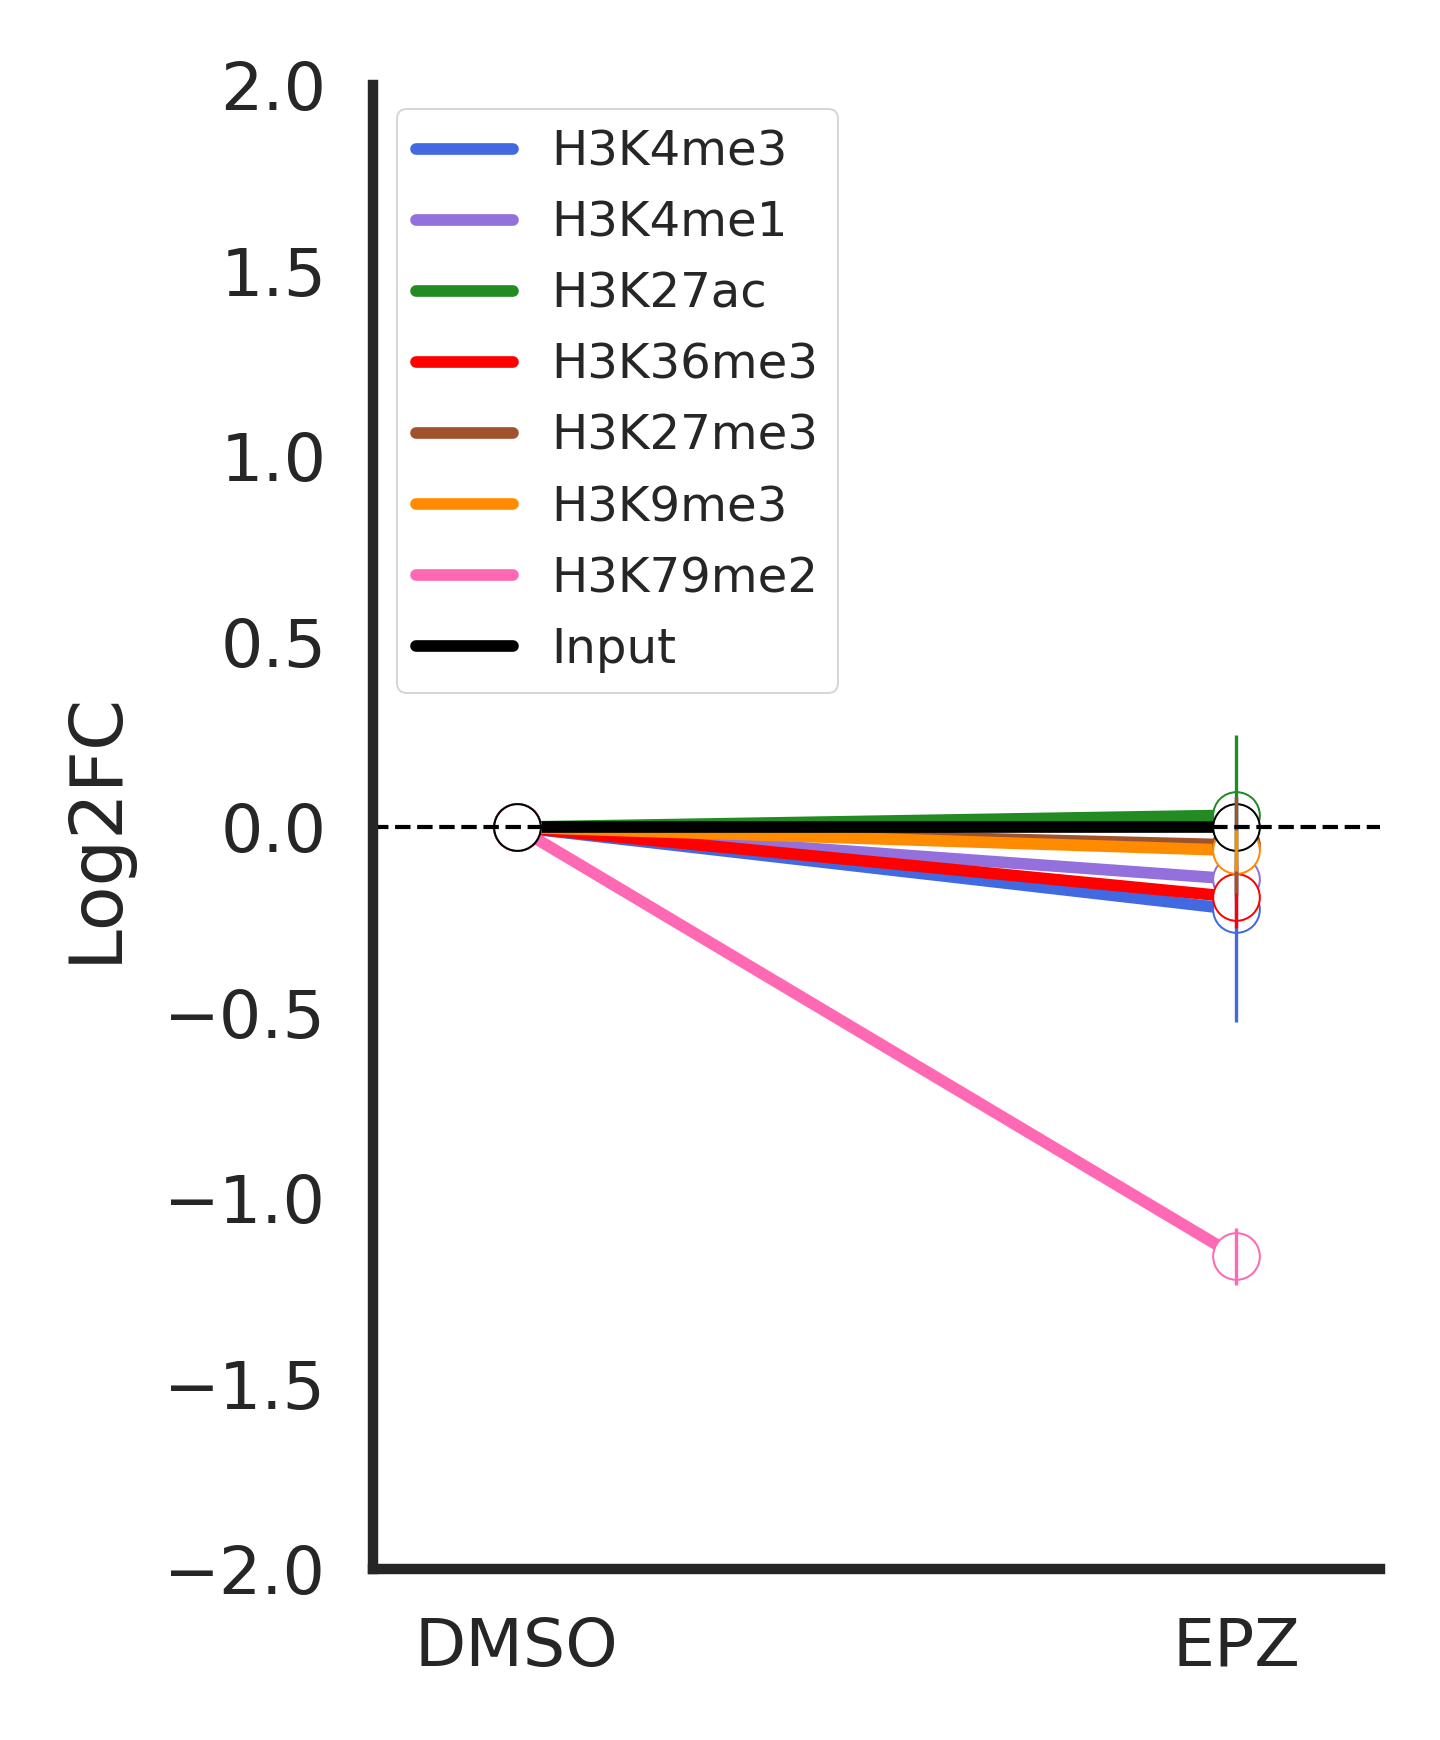

In [183]:
fig,ax = plt.subplots(dpi=600, figsize=(2.5,3))

cols={"H3K4me3":'royalblue',
      "H3K4me1":'mediumpurple',
      "H3K27ac":'forestgreen',
      "H3K36me3":'r',
      "H3K27me3":'sienna',
      "H3K9me3":'darkorange',
      "H3K79me2":'hotpink',
      "Input":'k'}

for i in ["H3K4me3","H3K4me1","H3K27ac","H3K36me3","H3K27me3","H3K9me3","H3K79me2","Input"]:
    
    inp = reads_ESC.loc[reads.mark == "Input"][["read_counts"]]
    

    markss = reads_ESC.loc[reads.mark == i][["read_counts"]]
#     print(markss)

    norm = markss.values/inp.values
    
   
    ratios = []
    for k in norm:
        a = list()
        for j in norm:
            a.append(k/j)
        ratios.append(list(a))
    iNPC = np.mean(np.log2(np.array(ratios)[2:,:2]))
    iNPC_std = np.std(np.log2(np.array(ratios)[2:,:2]))
#     mESC = np.mean(np.log2(np.array(ratios)[2:,:2]))
   
    ax.plot([0,1],[0,iNPC], label = i, zorder=0, color=cols[i])
    ax.errorbar([1],[iNPC],  yerr=iNPC_std, linewidth=0.4, capsize=0, color=cols[i])
    print(iNPC)
    ax.scatter([0,1],[0,iNPC], zorder=1,color=cols[i],edgecolor=cols[i], alpha=1, facecolor='white')
    
    ax.set_xticks(np.array([0,1]))
    ax.set_xticklabels(["DMSO","EPZ"])

    ax.legend(fontsize="xx-small", loc=2, frameon=True)
ax.set_ylabel("Log2FC")
ax.set_ylim(-2,2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.xlabel("differentiation trajectory")
#plt.annotate('', xy=(0.2, -0.1), xycoords='axes fraction', xytext=(0.8, -0.1), 
            #arrowprops=dict(arrowstyle="<-", color='k'))
#plt.title("NPC48h")
ax.set_xlim(-0.2,1.2)
ax.axhline(0, linewidth=0.5,linestyle='--', color='k')
plt.tight_layout()

plt.savefig("../FIGURES/Global_Change_mESC_EPZvsDMSO.pdf")
